# Clustering Yelp Restaurants

 You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, I tried to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Used the "longitude" and "latitude" to cluster closeness. Used "categories" to cluster for similarity.

Found clusters using the 3 different techniques: k-means++, hierarchical, and GMM.

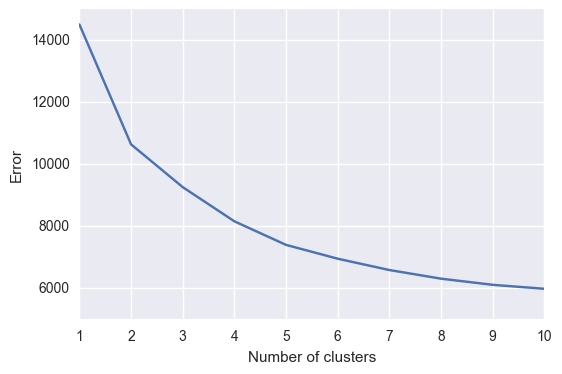

In [1]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.manifold import MDS
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer
from collections import OrderedDict
from scipy.cluster.hierarchy import fcluster,dendrogram, linkage, cophenet
from sklearn import mixture
from scipy.spatial.distance import pdist
%matplotlib inline

def extract(obj):
    ob = json.loads(obj)
    for key, value in list(ob.items()):
        if(key == 'categories'):
            if ('Restaurants' not in value):
                del ob[key]
            else:
                ob[key] = ','.join(value)    
    return ob


def process(data):
    return " ".join([SnowballStemmer('english').stem(word) for word in data])

def convert(j):
    for i in t15:
        if(i == j):
            return(t15.index(i)+1)

def appending(j):
    if j in t15:
        c.append(j)
        
def evaluate_clusters(final_df,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(final_df)
        error[k] = kmeans.inertia_
    plt.figure(1)
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
        
df = pd.DataFrame([extract(obj)for obj in open('yelp_academic_dataset_business.json')])



final_df = df[['latitude','longitude','city','categories']]
final_df = final_df.loc[final_df['city'] == 'Las Vegas']
final_df = final_df[['latitude','longitude','categories']]
final_df = final_df.dropna(subset=['categories'])
final_df[['latitude','longitude']] = (final_df[['latitude','longitude']].sub(final_df[['latitude','longitude']].mean())).divide(final_df[['latitude','longitude']].std())
top15_df = final_df.copy()
cat_list = final_df['categories'].tolist()
x = []
for i in cat_list:
     x += [i.split(',')]

        
count={}
for i in x:
    for j in i:
        if j not in count:
            count[j]=1
        else:
            count[j] = count[j] +1
top15_names=[]
od = OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))    
t15 = list(od)[1:16] # Eliminating Restaurants
top15_names = t15
t15_counts = list(od.values())[1:16]
trimmed_list = []
unwanted = []
c =[]
for i in final_df['categories']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in t15]]
    #c += [[ j for j in row if j in t15]]
    
    #trimmed_list.append(row)
#print(c)
top15_df['categories'] = c
top15_df = top15_df.reset_index(drop = True)
a = np.zeros(shape=(len(top15_df['categories']),15))
i=0
for j in c:
    for k in j:
        a[i,(k-1)] = 1
    i+=1
t15= pd.DataFrame.from_records(a)
t15[['latitude','longitude']] = top15_df[['latitude','longitude']]
evaluate_clusters(t15,10) #evaluates error versus number of clusters




#K-means 
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=100) 
km = kmeans.fit_predict(t15)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_


def labels(cluster):
    label_count ={}
    for i in cluster[0]:
        for j in top15_df['categories'][i]:
            if j not in label_count:
                label_count[j] = 1
            else:
                label_count[j] +=1
    ord_dict = OrderedDict(sorted(label_count.items(), key=lambda kv:kv[1], reverse=True))
    return ord_dict

def cluster_label(lc,t15_counts):
    maxi = 0
    for key,value in lc.items():
        temp = value/t15_counts[key-1]
        if(temp>maxi):
            maxi = temp
            index = key-1
    return top15_names[index]

all_labels = []
km_0 = np.where(km==0)
lc = labels(km_0)
all_labels.append(cluster_label(lc, t15_counts))

km_1 = np.where(km==1)
lc = labels(km_1)
all_labels.append(cluster_label(lc, t15_counts))

km_2 = np.where(km==2)
lc = labels(km_2)
all_labels.append(cluster_label(lc, t15_counts))

km_3 = np.where(km==3)
lc = labels(km_3)
all_labels.append(cluster_label(lc, t15_counts))

km_4 = np.where(km==4)
lc = labels(km_4)
all_labels.append(cluster_label(lc, t15_counts))




#Hierarchical
hc = linkage(t15, method ='complete',metric = 'euclidean')
cluster = fcluster(hc,5,criterion='distance')
all_labels_hc=[]

h_1 = np.where(cluster==1)
h= labels(h_1)
all_labels_hc.append(cluster_label(h, t15_counts))

h_2 = np.where(cluster==2)
h= labels(h_2)
all_labels_hc.append(cluster_label(h, t15_counts))

h_3 = np.where(cluster==3)
h= labels(h_3)
all_labels_hc.append(cluster_label(h, t15_counts))

h_4 = np.where(cluster==4)
h= labels(h_4)
all_labels_hc.append(cluster_label(h, t15_counts))

h_5 = np.where(cluster==5)
h= labels(h_5)
all_labels_hc.append(cluster_label(h, t15_counts))








#GMM
all_labels_gm=[]
gmm = mixture.GMM(n_components=5, covariance_type='spherical')
gmm.fit(t15)
gaussian = gmm.predict(t15)
mean = gmm.means_
covar = gmm.covars_

g_0 = np.where(gaussian==0)
x= labels(g_0)
all_labels_gm.append(cluster_label(x, t15_counts))

g_1 = np.where(gaussian==1)
x= labels(g_1)
all_labels_gm.append(cluster_label(x, t15_counts))

g_2 = np.where(gaussian==2)
x= labels(g_2)
all_labels_gm.append(cluster_label(x, t15_counts))

g_3 = np.where(gaussian==3)
x= labels(g_3)
all_labels_gm.append(cluster_label(x, t15_counts))

g_4 = np.where(gaussian==4)
x= labels(g_4)
all_labels_gm.append(cluster_label(x, t15_counts))




I parsed the data from the json file to a pandas dataframe. The final dataframe used for clustering has a total of 17 columns. Two of which are latitude and longitude and the remaining 15 are the columns of top15 categories of Restaurants in Las Vegas. If a category is present for a restaurant then its value for that column is 1.0 or else 0.I performed feature scaling on latitude and longitude by subtracting the mean of the entire column from each value and then dividing by the standard deviation (Also known as Z-score), thus scaling down the location to the range of categories. 

I also, plotted error versus number of clusters to select the appropriate number of clusters for kmeans++. As shown in the above plot, since there is a sharp decline till 5 and then the error decreases slowly. Hence, I selected 5 clusters for clustering. I used complete link method for heirarchical clustering i.e finding the distance between the two points farthest from each other in order to combine clusters during the agglomerative clustering method. Performed GMM using co-variance as 'spherical' so that each component has its own single variance.

Visualized the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Labelled each cluster with a category.

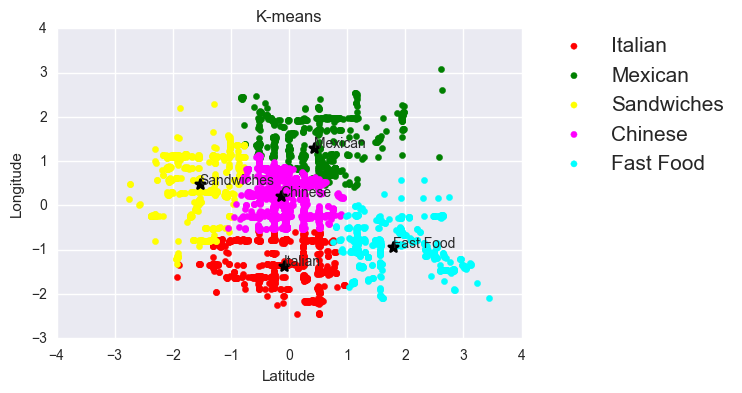

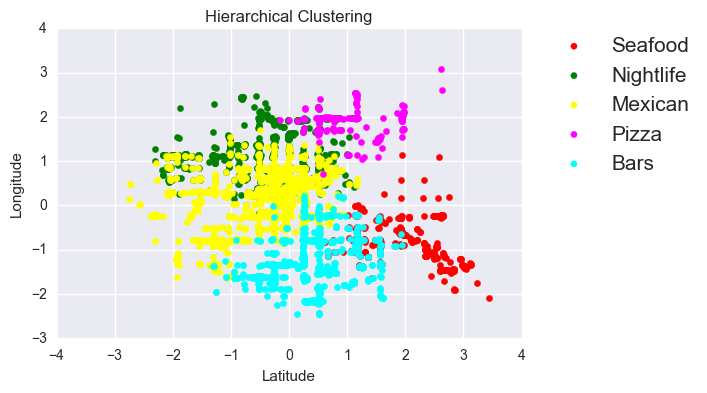

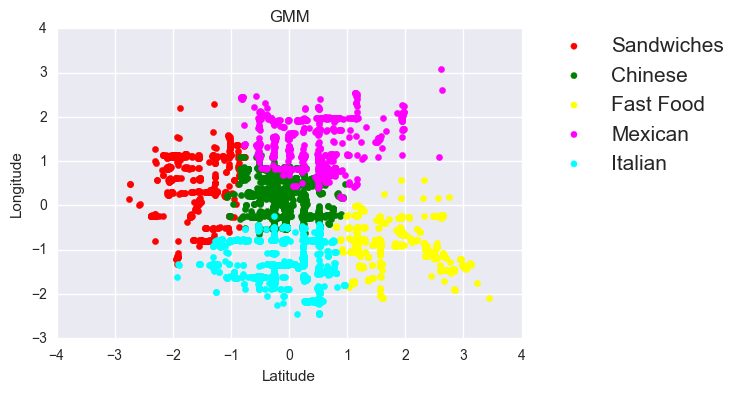

In [6]:
import matplotlib.pyplot as plt

#K-Means
clusters = [km_0,km_1,km_2,km_3,km_4]
colors = ['red','green','yellow','magenta','cyan']
plt.figure(0)

x = 0
for i in clusters:
    for j in i:
        plt.scatter(t15['latitude'][j],t15['longitude'][j], color=colors[x])
    x=x+1

y = 0    
for i in centroids:
    plt.scatter(i[15],i[16],s=50,c='black',marker='*',linewidth=2)
    plt.annotate(all_labels[y],xy=(i[15],i[16]))
    y+=1
plt.title('K-means')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
legend = plt.legend([all_labels[i] for i in range(len(all_labels))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
#referenced Stack overflow for legend tag and annotate
plt.show()

#Hierarchical
clusters_hc = [h_5,h_1,h_2,h_3,h_4]
colors = ['red','green','yellow','magenta','cyan']
plt.figure(1)

x = 0
for i in clusters_hc:
    for j in i:
        plt.scatter(t15['latitude'][j],t15['longitude'][j], color=colors[x])
    x=x+1

plt.title('Hierarchical Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
legend = plt.legend([all_labels_hc[i] for i in range(len(all_labels_hc))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
#referenced Stack overflow for legend tag and annotate
plt.show()

#GMM
clusters_gmm = [g_0,g_1,g_2,g_3,g_4]
colors = ['red','green','yellow','magenta','cyan']
plt.figure(2)

x = 0
for i in clusters_gmm:
    for j in i:
        plt.scatter(t15['latitude'][j],t15['longitude'][j], color=colors[x])
    x=x+1

plt.title('GMM')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
legend = plt.legend([all_labels_gm[i] for i in range(len(all_labels_gm))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
#referenced Stack overflow for legend tag and annotate
plt.show()



I calculated the ratio of each category present in the cluster with the total number of restaurants in Las Vegas of that category. And then selected the category having a maximum ratio as the label for that particular cluster. Thus, avoiding dominance by a particular category having large number of restaurants. This is implemented in the 'cluster_labels' function in the code section of Qst1.

**Below is the interpretation of the results of the three methods used.**

K-means: K-means has more well-defined clusters because it does hard-clustering i.e. each point belongs to one and only one cluster. also, since the function used is kmeans++, the initial points are calculated based on a probability function.

Hierarchical Clustering: Since it considers each point as a cluster on its own and then combines the points on the basis of distance between the points. It gives a result which varies quite a lot from the K-means and GMM clustering methods since it does not use any random points. The clustering can have more error because agglomerative clustering is susceptible to chaining.

Gaussian Mixture Model: GMM uses soft-clustering and hence has overlapping clusters.It calculates the probability of a point belonging to each cluster and hence is more likely to give better clustering. It gives clustering similar to K-means but with some overlapping points. Eg: Centre clusters in both GMM and Kmeans is Chinese.

----------